In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from typing import List, Tuple, Dict
import random
from sklearn import svm
import cachetools
from tqdm import tqdm
import multiprocessing

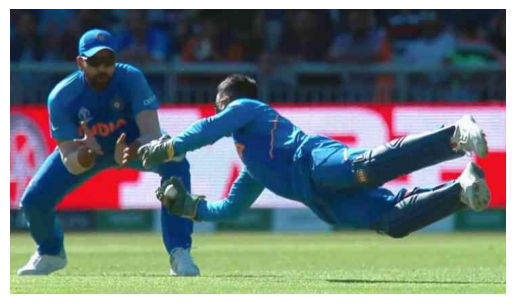

In [2]:
img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
assert img is not None
plt.axis("off")
plt.imshow(img)

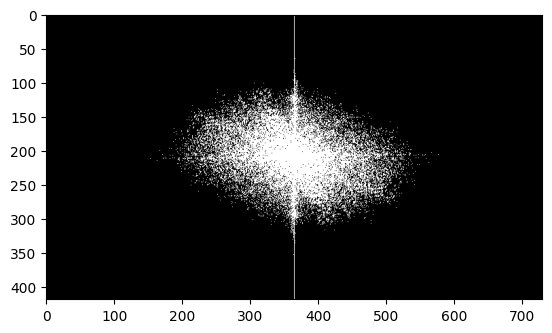

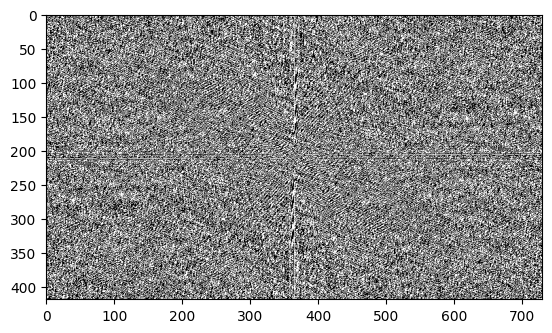

In [3]:
def get_fourier(img) -> Tuple[np.ndarray, np.ndarray]:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    fourier = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    
    fourier_shift = np.fft.fftshift(fourier)

    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))
    magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8UC1)
 
    phase = cv2.phase(fourier_shift[:,:,0],fourier_shift[:,:,1])
    phase = cv2.normalize(phase, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8UC1)


    
    return magnitude, phase
magnitude, phase = get_fourier(img)

plt.imshow(magnitude, cmap="gray")
plt.figure()
plt.imshow(phase, cmap="gray")

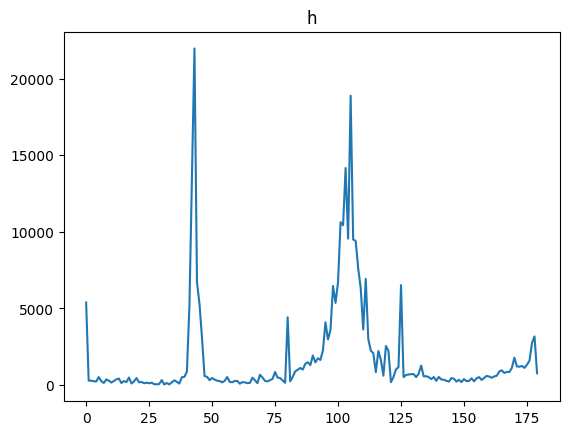

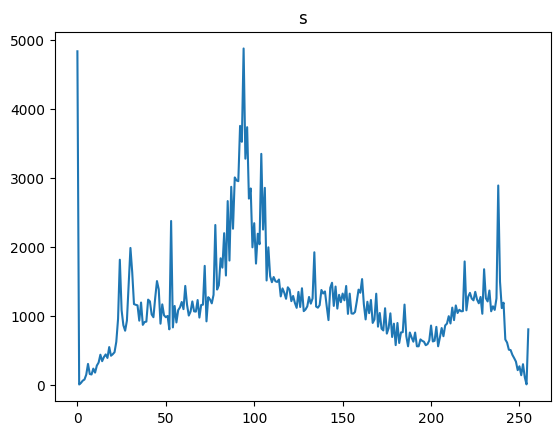

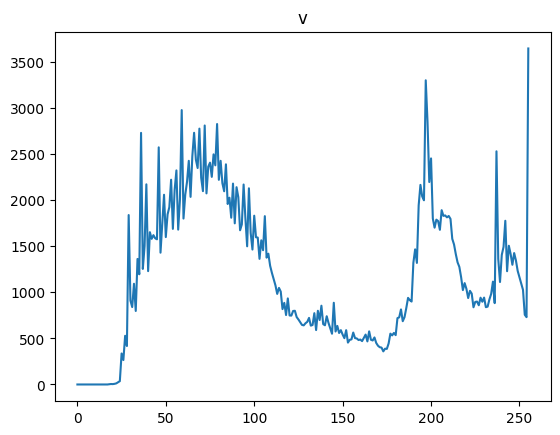

<Figure size 640x480 with 0 Axes>

In [4]:
def color_hist(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    hists = []
    maxes = (180, 256, 256)
    for i in range(3):
        hists.append(cv2.calcHist([hsv_img[:, :, i]],[0],None,[maxes[i]],[0,maxes[i]]))
    return hists

hists = color_hist(img)
title = "hsv"
for i in range(3):
    plt.title(title[i])
    plt.plot(hists[i])
    plt.figure()

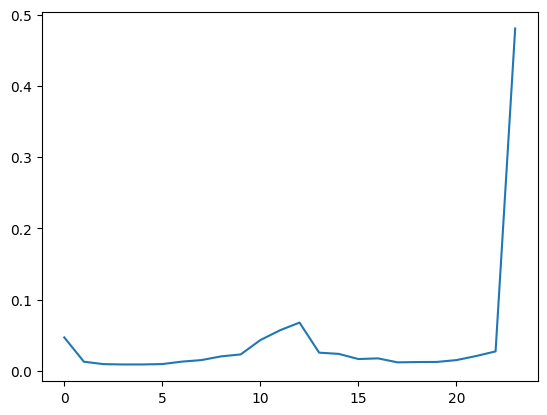

In [5]:
# https://cit.iict.bas.bg/CIT-2020/v-20-3/10341-Volume20_Issue_3-12_paper.pdf
# A Novel Feature Descriptor for Face Anti-Spoofing Using Texture Based Method
from skimage import feature
def calc_lbp(img, p = 24, r = 8):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()
    lbp = feature.local_binary_pattern(gray, p, r, method="uniform")
    # plt.imshow(lbp, cmap="gray")
    # plt.figure()
    hist, _ = np.histogram(lbp.ravel(), bins = p)

    hist = hist.astype("float")
    hist /= hist.sum() 
    return hist
hist = calc_lbp(img)
plt.plot(hist)

In [6]:
import cv2
import os
import matplotlib.pyplot as plt
@cachetools.cached(cache={})
def read_video(path: str, frame_index: int = None, min_brightness: int = 10):
    video = cv2.VideoCapture(path)
    if not video.isOpened():
        raise IOError(f"Error opening video file: {path}")
    

    
    frames = []
    def normalize(img):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
        img = cv2.normalize(phase, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8UC1)
        return img 
    
    while video.isOpened():
        ret, frame = video.read()
        frames.append(frame)
        if not ret:
            break
        if len(frames) >= frame_index and np.average(frame) > min_brightness:
            return normalize(frame)
    if frame_index is None:
        frame_index = len(frames) // 2
        while np.average(frames[frame_index]) < min_brightness:
            frame_index += 1
        return normalize(frames[frame_index]) 
    raise ValueError("frame not found")
REAL_FILES = (
    "1.avi",
    "2.avi",
    "HR_1.avi",
    "HR_4.avi",
)
def read_dir(path: str):
    real_images = []
    spoof_images = []
    for file in os.listdir(path):
        if os.path.isdir(os.path.join(path, file)):
            r, s = read_dir(os.path.join(path, file))
            real_images.extend(r)
            spoof_images.extend(s)
        else:
            if file.endswith(".avi"):
                obj = (os.path.join(path, file))
                if file in REAL_FILES:
                    real_images.append(obj)
                    
                else:
                    spoof_images.append(obj)
    return real_images, spoof_images


def show_data(ds, rows, cols):
    random.shuffle(ds)
    for i in range(rows):
        for j in range(cols):
            ind = i * cols + j 
            plt.subplot(rows, cols, ind + 1)
            plt.imshow(ds[ind])
            plt.axis("off")


def load_data(path: str, show = False):
    @cachetools.cached(cache={})
    def inner(path):
        r, s = read_dir(path)
        real = [read_video(i, frame_index=1) for i in r]
        spoof = [read_video(i, frame_index=1) for i in s]
        return real, spoof
    real, spoof = inner(path)
    if show:
        show_data(spoof, 4, 3)
        plt.figure()
        show_data(real, 4, 3)
    ds = [(i, 0) for i in real] + [(i, 1) for i in spoof]
    random.shuffle(ds)
    x = [i[0] for i in ds]
    y = [i[1] for i in ds]
    return x, y

In [7]:
def worker_pool(func, pool_size):
    Q = multiprocessing.Queue()
    pipes = []
    processes = []
    running = True

    def gateway(*args, **kwargs):
        out_reciever, out_sender = multiprocessing.Pipe()
        pipes.extend([out_reciever, out_sender])
        Q.put({
            "args": args,
            "kwargs": kwargs,
            "output": out_sender
        })
        return out_reciever

    def worker():
        while running:
            req = Q.get()
            args = req["args"]
            kwargs = req["kwargs"]
            out = req["output"]
            result = func(*args, **kwargs)
            out.send(result)

    def cancel():
        nonlocal running
        for p in pipes:
            p.close()
        running = False

        for p in processes:
            p.terminate()

    for _ in range(pool_size):
        processes.append(multiprocessing.Process(target=worker))
        processes[-1].start()

    return (gateway, cancel)
feature_extractor, _ = worker_pool(lambda img: calc_lbp(img, ), 16)

In [9]:
x_train, y_train = load_data("/home/mpc/w/uni/CV/project/datasets/train_release")
x_test, y_test = load_data("/home/mpc/w/uni/CV/project/datasets/test_release")

x_train = [feature_extractor(i) for i in x_train]
x_train = [i.recv() for i in tqdm(x_train)]

x_test = [feature_extractor(i) for i in x_test]
x_test = [i.recv() for i in tqdm(x_test)]



100%|██████████| 360/360 [00:06<00:00, 58.88it/s]


In [10]:
print(np.array(x_train).shape)
classifier = svm.SVC(kernel="rbf", probability = True)
classifier.fit(x_train, y_train)
print(classifier.score(x_test, y_test), "test")
print(classifier.score(x_train, y_train), "train")
print(classifier.predict(x_test))
print(y_train)

(240, 24)
0.6666666666666666 test
0.6666666666666666 train
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,